# Turing Target Practice

## Model

In [1]:
] activate "."

  Activating project at `~/Glamdring/MicroCanonicalHMC.jl`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
#using StatsPlots
using PyPlot
using Distributed

using Revise
using MicroCanonicalHMC

[ Info: Precompiling MicroCanonicalHMC [234d2aa0-2291-45f7-9047-6fa6f316b0a8]


In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm  ~ Uniform(0.01, 0.6)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [12]:
target = TuringTarget(stat_model);

In [13]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples_mchmc = Sample(spl, target, 100_000;
                       burn_in=100,  
                       file_name="Turing_sequential_samples",
                       dialog=true);

Initial Virial loss: 13.946960019084422
Virial loss: 

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳


3.8947168878192286 --> Relative improvement: 0.7207479707054537
Virial loss: 3.7309585346771286 --> Relative improvement: 0.0420462790644055
Virial loss: 3.227508383064418 --> Relative improvement: 0.1349385545117774
Virial loss: 2.3832219268954873 --> Relative improvement: 0.261590786440439
Virial loss: 1.1965061440806295 --> Relative improvement: 0.49794598204319873
Virial loss: 0.33485655673345605 --> Relative improvement: 0.7201380382457184
Using eps tuning method AdaptiveStep


[ Info: Virial loss condition met during burn-in at step: 6


eps: 0.07 --> VarE/d: 599.7838712299146
eps: 0.020885204765709545 --> VarE/d: 48.10848909746789
eps: 0.009253826021053877 --> VarE/d: 9.124452659742026
eps: 0.00548448338219244 --> VarE/d: 3.1204384384943125
eps: 0.003862625287034769 --> VarE/d: 1.5442029920748481
eps: 0.003008478380549681 --> VarE/d: 0.9285734538546653
eps: 0.00249300408837426 --> VarE/d: 0.6316605135580614
eps: 0.002151176952533092 --> VarE/d: 0.4532408805540316
eps: 0.0019097418643230213 --> VarE/d: 0.3569526339771034
eps: 0.0017293716306097946 --> VarE/d: 0.3003357090519506
eps: 0.0015885161176467334 --> VarE/d: 0.24697355752880312
eps: 0.0014763525741090255 --> VarE/d: 0.2082483798635714
eps: 0.0013848582025389005 --> VarE/d: 0.18956524067103533
eps: 0.0013075829954924435 --> VarE/d: 0.16288132725525822
eps: 0.001242482896673601 --> VarE/d: 0.15195468376680443
eps: 0.0011857495014792154 --> VarE/d: 0.13117608583469392
eps: 0.001137018585998557 --> VarE/d: 0.12674368509768616
eps: 0.0010933102763934276 --> VarE/d: 

[ Info: Found L: 0.08565142156357064 ✅
[ Info: Final nu 0.07334025602774275


In [14]:
std(samples_mchmc)[1:end-2]

2-element Vector{Float64}:
 0.06737809600545025
 0.10090159274432506

In [15]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

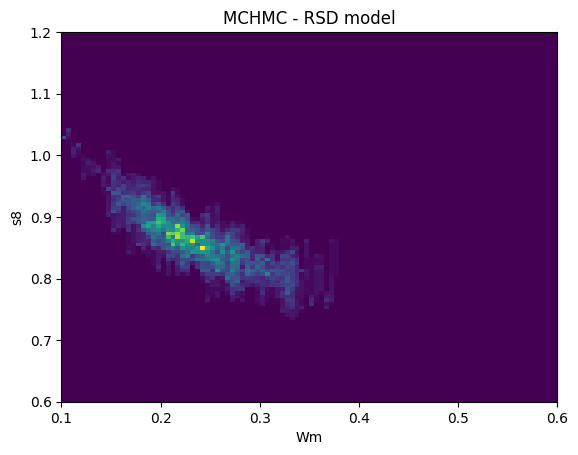

In [16]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

In [17]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples_ensemble_mchmc = Sample(spl, target, 10000;
                                burn_in=1000,
                                monitor_energy=true, 
                                dialog=true);

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Initial nu 0.4019513728906998
[ Info: Starting burn in ⏳


Initial Virial loss: 14396.758089947807
Virial loss: 117.26426236415524 --> Relative improvement: 0.9918548146998433
Virial loss: 98.64287425133891 --> Relative improvement: 0.158798492715445
Virial loss: 72.07533790368073 --> Relative improvement: 0.26933051727553003
Virial loss: 49.57390068076135 --> Relative improvement: 0.31219329492411974
Virial loss: 43.13023920322676 --> Relative improvement: 0.12998092522574578
Virial loss: 39.800874850049446 --> Relative improvement: 0.07719327355198691
Virial loss: 39.705337246217404 --> Relative improvement: 0.002400389543998238


[ Info: Virial loss condition met during burn-in at step: 7
[ Info: Found sigma: [0.9923099126133966, 0.12377817791999264] ✅


Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 2.9398130457478517
eps: 0.04218389364126078 --> VarE/d: 1.0281659943982686
eps: 0.03468220562290873 --> VarE/d: 0.6964133011823245
eps: 0.030976050478765973 --> VarE/d: 0.5252458217214828
eps: 0.02875260779190408 --> VarE/d: 0.4373601832273158
eps: 0.02723572900527331 --> VarE/d: 0.3856221992310063
eps: 0.026111869125028813 --> VarE/d: 0.33532784633922014
eps: 0.02526322810013586 --> VarE/d: 0.28951635861095826
eps: 0.024616959790088804 --> VarE/d: 0.27351566943501515
eps: 0.024076774949525207 --> VarE/d: 0.25776538429378654
eps: 0.023620590493755124 --> VarE/d: 0.23571420042441824
eps: 0.02324470659374654 --> VarE/d: 0.22969777944781336
eps: 0.022909938026090402 --> VarE/d: 0.20620486884427458
eps: 0.02263951641358472 --> VarE/d: 0.2033374497256332
eps: 0.022391939748722965 --> VarE/d: 0.187446231646289
eps: 0.02218574174803511 --> VarE/d: 0.18286823071148517
eps: 0.021998527281147467 --> VarE/d: 0.16561111527102576
eps: 0.021

[ Info: Found eps: 0.021188390136720928 ✅
[ Info: Final nu 0.21029597822755663


In [18]:
Wms_ensemble_mchmc = [sample[1] for sample in samples_ensemble_mchmc]
s8s_ensemble_mchmc = [sample[2] for sample in samples_ensemble_mchmc];

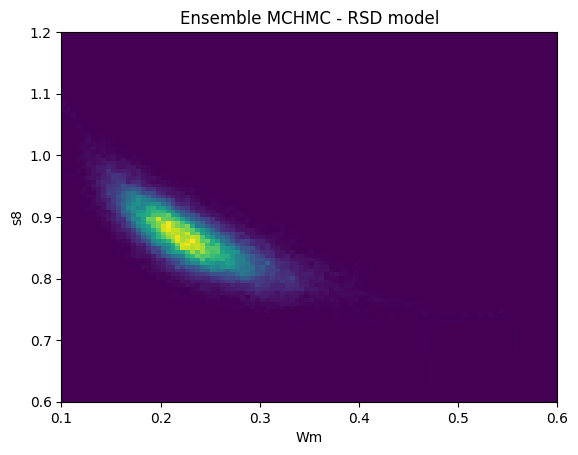

In [19]:
plt.hist2d(Wms_ensemble_mchmc, s8s_ensemble_mchmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("Ensemble MCHMC - RSD model");

##  AbstractMCMC

In [28]:
spl = MCHMC(0.0, 0.0; init_eps=0.07, varE_wanted=0.01, sigma=ones(2))
samples = sample(stat_model, spl, 1_000; burn_in=100, dialog=true)

Initial Virial loss: 26.733647484372398
Virial loss: 24.627533530231105 --> Relative improvement: 0.07878139170393628
Virial loss: 9.506346123034099 --> Relative improvement: 0.6139952012910774
Virial loss: 9.28132443472154 --> Relative improvement: 0.0236706811849956
Virial loss: 8.385138890575732 --> Relative improvement: 0.09655793744189867
Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 1.7109650775615097
eps: 0.03297861194539882 --> VarE/d: 0.770899593533225
eps: 0.022897649442043894 --> VarE/d: 0.07846544731343949
eps: 0.02001981068481862 --> VarE/d: 0.031123025214222593
eps: 0.018922654223531413 --> VarE/d: 0.06059300724300522
eps: 0.017650528743601228 --> VarE/d: 0.053892581030131545
eps: 0.016709123137556573 --> VarE/d: 0.04626333054903974
eps: 0.016000074950990196 --> VarE/d: 0.028029558143484467
eps: 0.01558633289604892 --> VarE/d: 0.012114094750840068
eps: 0.015517391672362385 --> VarE/d: 0.022522735046635108
eps: 0.015256724518440281 --> VarE/d: 0.04257779662867

[ Info: Using given sigma ✅
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Initial nu 0.2281016476686452
[ Info: Starting burn in ⏳
┌ Warning: Maximum number of steps reached during burn-in
└ @ MicroCanonicalHMC ~/Glamdring/MicroCanonicalHMC.jl/src/tuning.jl:259
[ Info: Found eps: 0.01381918596383384 ✅
[ Info: Found L: 0.22860805031820228 ✅
[ Info: Final nu 0.2534860651344358


Chains MCMC chain (1000×4×1 Array{Float64, 3}):

Iterations        = 101:1:1100
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.06 seconds
Compute duration  = 0.06 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2422    0.0501     0.0016    0.0087   12.1570    1.0993      ⋯
          σ8    0.8574    0.0446     0.0014    0.0065   17.3561    1.0690      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1502    0.2020    0.2440    0.2780    0.3324
          σ8    0.7767    0.8278    0.8524    0.8862    0.9561


In [26]:
new_samples = sample(stat_model, spl, 1_000; 
                     monitor_energy=true, 
                     progress=true, resume_from=samples)

[ Info: Starting from previous run


Chains MCMC chain (1000×4×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.23 seconds
Compute duration  = 0.23 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2410    0.0373     0.0012    0.0065   15.3820    1.0111      ⋯
          σ8    0.8564    0.0375     0.0012    0.0045   71.2276    1.0007      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1907    0.2099    0.2351    0.2690    0.3209
          σ8    0.7871    0.8311    0.8535    0.8799    0.9392


## Ensemble AbstractMCMC

In [30]:
spl = MCHMC(0.0, 0.5, 10; init_eps=0.07, varE_wanted=0.1)
samples = sample(stat_model, spl, 1000; burn_in=100, dialog=true)

Initial Virial loss: 42816.39325998224
Virial loss: 158.11882016222364 --> Relative improvement: 0.9963070495171762
Virial loss: 119.77926753516712 --> Relative improvement: 0.24247305025247257
Virial loss: 98.88191675260381 --> Relative improvement: 0.1744655082018084
Virial loss: 74.25306757715363 --> Relative improvement: 0.2490733390319484
Virial loss: 59.34951317655382 --> Relative improvement: 0.20071297909832575
Virial loss: 58.84813260382773 --> Relative improvement: 0.008447930671892423
Using eps tuning method AdaptiveStep
eps: 0.07 --> VarE/d: 24.89021685146009
eps: 0.03139257921978017 --> VarE/d: 4.948072162114154
eps: 0.022261198694975032 --> VarE/d: 2.3850432737855733
eps: 0.01829199146052613 --> VarE/d: 1.5771326562296877
eps: 0.01604037401678111 --> VarE/d: 1.193841639339198
eps: 0.014568805546982744 --> VarE/d: 0.9465580528348905
eps: 0.013530007778955097 --> VarE/d: 0.8053381125279706
eps: 0.012745208001348285 --> VarE/d: 0.6832488620293122
eps: 0.012136022414603802 --

[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Using given L ✅
[ Info: Initial nu 0.4019513728906998
[ Info: Starting burn in ⏳
[ Info: Virial loss condition met during burn-in at step: 8
[ Info: Found sigma: [0.9745540340956919, 0.22415270381553148] ✅


eps: 0.008587222617388356 --> VarE/d: 0.2392643451696585
eps: 0.008509526522125332 --> VarE/d: 0.22990455848165325
eps: 0.008437642281916666 --> VarE/d: 0.2445586741185497
eps: 0.008362837715331129 --> VarE/d: 0.22495679418121903
eps: 0.008296820017605145 --> VarE/d: 0.22771833746640083
eps: 0.00823162128257678 --> VarE/d: 0.22930917072448861
eps: 0.008167567489260697 --> VarE/d: 0.21878449924866755
eps: 0.008108552565945037 --> VarE/d: 0.21243266514184053
eps: 0.008053032814605898 --> VarE/d: 0.20938013042975956
eps: 0.007999756413199046 --> VarE/d: 0.2103127148169115
eps: 0.007947287398846464 --> VarE/d: 0.20320313726885622
eps: 0.007898213224696575 --> VarE/d: 0.1843754347529582
eps: 0.007856589234258651 --> VarE/d: 0.19063425971011616
eps: 0.007813497396481985 --> VarE/d: 0.18472311358791296
eps: 0.007773187123613175 --> VarE/d: 0.18528641775505647
eps: 0.00773333963311576 --> VarE/d: 0.1808199196638038
eps: 0.007695651685786139 --> VarE/d: 0.17976769293323205
eps: 0.00765888932349

[ Info: Found eps: 0.007135692958770643 ✅
[ Info: Final nu 0.12032044744139486
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 101:1:10100
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.92 seconds
Compute duration  = 0.92 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2944    0.1392     0.0014    0.0140   23.2804    1.0009      ⋯
          σ8    0.8784    0.1103     0.0011    0.0111   23.0822    1.1013      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1206    0.1725    0.2738    0.3709    0.5384
          σ8    0.7764    0.7928    0.8453    0.9260    1.1625


In [31]:
new_samples = sample(stat_model, spl, 1000; burn_in=100, 
                     resume_from=samples)

[ Info: Starting from previous run
Chain 1: 100%|██████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (10000×4×1 Array{Float64, 3}):

Iterations        = 101:1:10100
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 0.71 seconds
Compute duration  = 0.71 seconds
parameters        = Ωm, σ8
internals         = E, logp

Summary Statistics
  parameters      mean       std   naive_se      mcse       ess      rhat   es ⋯
      Symbol   Float64   Float64    Float64   Float64   Float64   Float64      ⋯

          Ωm    0.2425    0.0586     0.0006    0.0059   21.6879    1.2264      ⋯
          σ8    0.8682    0.0641     0.0006    0.0064   21.8506    1.2295      ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          Ωm    0.1421    0.1910    0.2378    0.3052    0.3148
          σ8    0.7856    0.8103    0.8604    0.9053    1.0142


## Parallelization

In [18]:
samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true)

[ Info: number of chains: 4 smaller than number of threads: 10. Increase the number of chains to make full use of your threads.
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning sigma ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning L ⏳
[ Info: Tuning eps ⏳
[ Info: Tuning L ⏳


LoadError: TaskFailedException

[91m    nested task error: [39mDomainError with -0.33934227649544785:
    sqrt will only return a complex result if called with a complex argument. Try sqrt(Complex(x)).
    Stacktrace:
      [1] [0m[1mthrow_complex_domainerror[22m[0m[1m([22m[90mf[39m::[0mSymbol, [90mx[39m::[0mFloat64[0m[1m)[22m
    [90m    @[39m [90mBase.Math[39m [90m./[39m[90m[4mmath.jl:33[24m[39m
      [2] [0m[1msqrt[22m
    [90m    @[39m [90m./[39m[90m[4mmath.jl:677[24m[39m[90m [inlined][39m
      [3] [0m[1m_broadcast_getindex_evalf[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:683[24m[39m[90m [inlined][39m
      [4] [0m[1m_broadcast_getindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:656[24m[39m[90m [inlined][39m
      [5] [0m[1mgetindex[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:610[24m[39m[90m [inlined][39m
      [6] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:974[24m[39m[90m [inlined][39m
      [7] [0m[1mmacro expansion[22m
    [90m    @[39m [90m./[39m[90m[4msimdloop.jl:77[24m[39m[90m [inlined][39m
      [8] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:973[24m[39m[90m [inlined][39m
      [9] [0m[1mcopyto![22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:926[24m[39m[90m [inlined][39m
     [10] [0m[1mcopy[22m
    [90m    @[39m [90m./[39m[90m[4mbroadcast.jl:898[24m[39m[90m [inlined][39m
     [11] [0m[1mmaterialize[22m[0m[1m([22m[90mbc[39m::[0mBase.Broadcast.Broadcasted[90m{Base.Broadcast.DefaultArrayStyle{1}, Nothing, typeof(sqrt), Tuple{Vector{Float64}}}[39m[0m[1m)[22m
    [90m    @[39m [90mBase.Broadcast[39m [90m./[39m[90m[4mbroadcast.jl:873[24m[39m
     [12] [0m[1mtune_sigma![22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:89[24m[39m
     [13] [0m[1mtune_sigma![22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:83[24m[39m[90m [inlined][39m
     [14] [0m[1mtune_hyperparameters[22m[0m[1m([22m[90msampler[39m::[0mMicroCanonicalHMC.Sampler, [90mtarget[39m::[0mTuringTarget, [90minit[39m::[0mTuple[90m{Vector{Float64}, Vector{Float64}, Float64, Vector{Float64}, Float64}[39m; [90mkwargs[39m::[0mBase.Pairs[90m{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}[39m[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mtuning.jl:155[24m[39m
     [15] [0m[1mmacro expansion[22m
    [90m    @[39m [90m~/PhD/MicroCanonicalHMC.jl/src/[39m[90m[4mabstractmcmc.jl:220[24m[39m[90m [inlined][39m
     [16] [0m[1m(::MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}})[22m[0m[1m([22m[90mtid[39m::[0mInt64; [90monethread[39m::[0mBool[0m[1m)[22m
    [90m    @[39m [35mMicroCanonicalHMC[39m [90m./[39m[90m[4mthreadingconstructs.jl:139[24m[39m
     [17] [0m[1m#902#threadsfor_fun[22m
    [90m    @[39m [90m./[39m[90m[4mthreadingconstructs.jl:106[24m[39m[90m [inlined][39m
     [18] [0m[1m(::Base.Threads.var"#1#2"{MicroCanonicalHMC.var"#902#threadsfor_fun#95"{MicroCanonicalHMC.var"#902#threadsfor_fun#84#96"{Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:monitor_energy, :dialog), Tuple{Bool, Bool}}}, UnitRange{Int64}}}, Int64})[22m[0m[1m([22m[0m[1m)[22m
    [90m    @[39m [90mBase.Threads[39m [90m./[39m[90m[4mthreadingconstructs.jl:84[24m[39m

...and 3 more exceptions.


In [19]:
new_samples = sample(
    stat_model, MCHMC(varE_wanted=2.0), MCMCThreads(), 30000, 4;
    monitor_energy=true, 
    dialog=true, 
    resume_from=samples)

[ Info: Starting from previous run


LoadError: MethodError: no method matching iterate(::Chains{Float64, AxisArrays.AxisArray{Float64, 3, Array{Float64, 3}, Tuple{AxisArrays.Axis{:iter, StepRange{Int64, Int64}}, AxisArrays.Axis{:var, Vector{Symbol}}, AxisArrays.Axis{:chain, UnitRange{Int64}}}}, Missing, NamedTuple{(:parameters, :internals), Tuple{Vector{Symbol}, Vector{Symbol}}}, NamedTuple{(:target, :sampler, :init, :start_time, :stop_time), Tuple{ParallelTarget, MicroCanonicalHMC.EnsembleSampler, Tuple{Tuple{Matrix{Float64}, Matrix{Float64}, Vector{Real}, Matrix{Real}, Vector{Float64}}, Tuple{Matrix{Real}, Vector{Float64}, Vector{Float64}}}, Float64, Float64}}})

[0mClosest candidates are:
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::Union{LinRange, StepRangeLen}[39m, [91m::Integer[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mrange.jl:880[24m[39m
[0m  iterate([91m::T[39m) where T<:Union{Base.KeySet{<:Any, <:Dict}, Base.ValueIterator{<:Dict}}
[0m[90m   @[39m [90mBase[39m [90m[4mdict.jl:698[24m[39m
[0m  ...


## NUTS

In [28]:
typeof(zeros(2,2,2))

Array{Float64, 3}

In [20]:
samples_hmc = sample(stat_model, NUTS(10, 0.65),
                     10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:07


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 11:1:10010
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 11.66 seconds
Compute duration  = 11.66 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2403    0.0683     0.0007    0.0017   1405.0343    1.0006    ⋯
          σ8    0.8637    0.0619     0.0006    0.0012   2356.8676    1.0002    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

     

In [21]:
samples_hmc.value

3-dimensional AxisArray{Float64,3,...} with axes:
    :iter, 11:1:10010
    :var, [:Ωm, :σ8, :lp, :n_steps, :is_accept, :acceptance_rate, :log_density, :hamiltonian_energy, :hamiltonian_energy_error, :max_hamiltonian_energy_error, :tree_depth, :numerical_error, :step_size, :nom_step_size]
    :chain, 1:1
And data, a 10000×14×1 Array{Float64, 3}:
[:, :, 1] =
 0.195289  0.931189  15.6471   7.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.194965  0.891184  16.194    3.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.20792   0.883536  16.2748  15.0  1.0     3.0  0.0  0.0471045  0.0471045
 0.252361  0.838644  16.1968  31.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.251986  0.825046  16.0557   1.0  1.0     1.0  0.0  0.0471045  0.0471045
 0.24801   0.831916  16.1395   3.0  1.0  …  2.0  0.0  0.0471045  0.0471045
 0.195668  0.864144  15.9732  21.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.264617  0.863147  15.8853  19.0  1.0     4.0  0.0  0.0471045  0.0471045
 0.272399  0.787847  15.258    7.0  1.0 

In [22]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

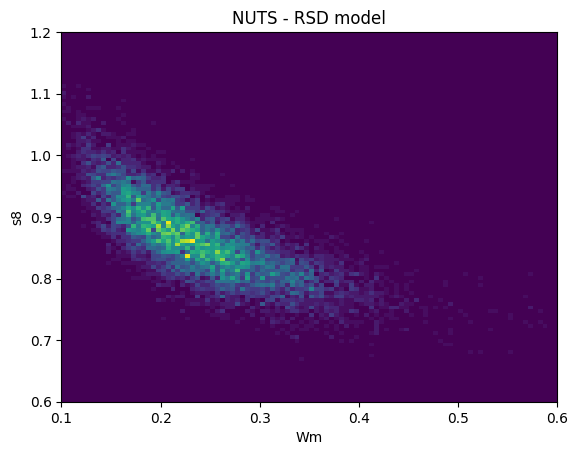

In [23]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.6],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("NUTS - RSD model");